# importing libraries

In [1]:
import re, json, os, itertools
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy.lang.en import English
from spacy.training import offsets_to_biluo_tags # requires spaCy 3.0

### 1. File handling

In [17]:
### paths
JSONL_FILE = 'dataproject.jsonl'
FEATURE_CLASS_LABELS = "feature_class_labels.json"
DATA_FILE = 'v1-annotated.json'

### 2. Text Data Preprocessing 

### Prepare updated dataset for  Transformers with HuggingFace

In [3]:
df = pd.read_json (JSONL_FILE, lines=True)
df = df.drop(['meta', 'annotation_approver', 'comments'], axis=1)
df.head()

,id,text,labels
0,4,"""Sudeep, did she invite him though? No right? ...","[[155, 161, Insult]]"
1,5,@discerningmumin Islam has never been a resist...,[]
2,6,"""Boy, your comment about Journalists wanting t...","[[206, 219, Harassment]]"
3,7,@ShashiTharoor @INCIndia Hindus were and are g...,"[[63, 82, Harassment], [215, 221, Insult]]"
4,8,"""White supremicists? How many do you know? The...","[[55, 61, Insult]]"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      80 non-null     int64 
 1   text    80 non-null     object
 2   labels  80 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.0+ KB


In [5]:
# delet any any rows  which  not annotated.
df_cut = df[df['labels'].map(lambda d: len(d)) > 0].copy()
df_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 0 to 74
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      48 non-null     int64 
 1   text    48 non-null     object
 2   labels  48 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.5+ KB


In [6]:
# tokenize each agreement prior to put it  into the transformer model
# Create tokens format by using spaCy
nlp = English()
df_cut['tokens'] = df_cut['text'].apply(lambda x: nlp(x))
df_cut.head()

,id,text,labels,tokens
0,4,"""Sudeep, did she invite him though? No right? ...","[[155, 161, Insult]]","("", Sudeep, ,, did, she, invite, him, though, ..."
2,6,"""Boy, your comment about Journalists wanting t...","[[206, 219, Harassment]]","("", Boy, ,, your, comment, about, Journalists,..."
3,7,@ShashiTharoor @INCIndia Hindus were and are g...,"[[63, 82, Harassment], [215, 221, Insult]]","(@ShashiTharoor, @INCIndia, Hindus, were, and,..."
4,8,"""White supremicists? How many do you know? The...","[[55, 61, Insult]]","("", White, supremicists, ?, How, many, do, you..."
5,9,Urban naxal and a jihadi TT gang put together....,"[[196, 217, Harassment], [149, 162, Harassment]]","(Urban, naxal, and, a, jihadi, TT, gang, put, ..."


In [7]:
# Checking one  example of the text indices and labels """"""""""
row = df_cut.iloc[4]
doc = row['tokens']
for start, end, label in row['labels']:
    print(start, end, label)
print("\n")
print(doc)

196 217 Harassment
149 162 Harassment


Urban naxal and a jihadi TT gang put together..wen more than 95% ot the population are happy to be united as one nation inspite of their diversity...who the F are u to preach otherwise..ur just a petty muslim activist...or should i say ground operative for Islamic Terrorism


C:\Users\ce pc\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


The total number of labels in the dataset is: 102


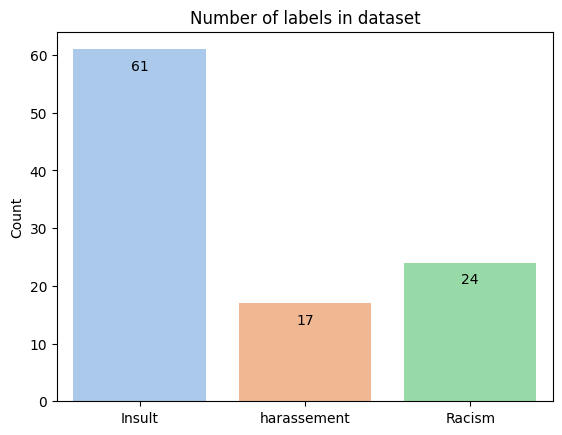

In [21]:
# Count and visualise some  labels
insult_num = 0
harassement_num = 0
racism_num = 0
for index, row in df_cut.iterrows():
    for l in row['labels']:
        if l[2] == "Insult":
            insult_num += 1
        if l[2] == "Harassment":
            harassement_num += 1
        if l[2] == "Racism":
            racism_num += 1

# Create DataFrame for chaque plot
data=pd.DataFrame.from_dict({"Insult":[insult_num],
                             "harassement":[harassement_num],
                             "Racism":[racism_num]})

# using sea born
splot = sns.barplot(palette="pastel", data=data)
splot.set(title='Number of labels in dataset', ylabel='Count')

# bars lables 
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2.,p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, -12), 
                   textcoords = 'offset points')

plt.show

print("The total number of labels in the dataset is:", insult_num+harassement_num+racism_num)

In [11]:
# how the entity labels match up with the tokens
ents=[]

for start, end, label in row['labels']:
    if doc.char_span(start, end, label) != None:
        ent = doc.char_span(start, end, label)
        ents.append(ent)
    elif doc.char_span(start, end+1, label) != None:
        ent = doc.char_span(start, end+1, label)
        ents.append(ent)
    elif doc.char_span(start+1, end, label) != None:
        ent = doc.char_span(start+1, end, label)
        ents.append(ent)
    elif doc.char_span(start, end-1, label) != None:
        ent = doc.char_span(start, end-1, label)
        ents.append(ent)
doc.ents = ents
doc.ents

()

In [12]:
# Each word should be seperated applying the IOB format
# Create tags using token.ent_iob_ and add to the DataFrame
# Allow for any character misalignment between spaCy tokenization and Doccano character indices
tags_list_iob = []
for index, row in df_cut.iterrows():
    doc = row['tokens']
    ents=[]
    for start, end, label in row['labels']:
        if doc.char_span(start, end, label) != None:
            ent = doc.char_span(start, end, label)
            ents.append(ent)
        elif doc.char_span(start, end+1, label) != None:
            ent = doc.char_span(start, end+1, label)
            ents.append(ent)
        elif doc.char_span(start+1, end, label) != None:
            ent = doc.char_span(start+1, end, label)
            ents.append(ent)
        elif doc.char_span(start, end-1, label) != None:
            ent = doc.char_span(start, end-1, label)
            ents.append(ent)
        elif doc.char_span(start-1, end, label) != None:
            ent = doc.char_span(start-1, end, label)
            ents.append(ent)
    doc.ents = ents
    iob_tags = [f"{t.ent_iob_}-{t.ent_type_}" if t.ent_iob_ != "O" else "O" for t in doc]
    tags_list_iob.append(iob_tags)
df_cut['tags'] = tags_list_iob

In [13]:
df_cut.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 0 to 74
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      48 non-null     int64 
 1   text    48 non-null     object
 2   labels  48 non-null     object
 3   tokens  48 non-null     object
 4   tags    48 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.2+ KB


In [14]:
# Generate list of the IOB feature class labels from tags
all_tags = list(itertools.chain.from_iterable(tags_list_iob))

def unique(list1):
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    unique_list.sort()
    return unique_list

feature_class_labels = unique(all_tags)
print(feature_class_labels)

['B-Doxing', 'B-Harassment', 'B-Insult', 'B-Racism', 'B-Sexism', 'B-Trolling', 'I-Doxing', 'I-Harassment', 'I-Insult', 'I-Racism', 'I-Sexism', 'I-Trolling', 'O']


In [15]:
# Generate the NER index tags for each token
df_cut['ner_tags'] = df_cut['tags'].apply(lambda x: [feature_class_labels.index(tag) for tag in x])

In [16]:
# Split tokens into a list ready for CSV
df_cut['split_tokens'] = df_cut['tokens'].apply(lambda x: [tok.text for tok in x])

# Check dataframe head
df_cut.head()

,id,text,labels,tokens,tags,ner_tags,split_tokens
0,4,"""Sudeep, did she invite him though? No right? ...","[[155, 161, Insult]]","("", Sudeep, ,, did, she, invite, him, though, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...","["", Sudeep, ,, did, she, invite, him, though, ..."
2,6,"""Boy, your comment about Journalists wanting t...","[[206, 219, Harassment]]","("", Boy, ,, your, comment, about, Journalists,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...","["", Boy, ,, your, comment, about, Journalists,..."
3,7,@ShashiTharoor @INCIndia Hindus were and are g...,"[[63, 82, Harassment], [215, 221, Insult]]","(@ShashiTharoor, @INCIndia, Hindus, were, and,...","[O, O, O, O, O, O, O, O, O, B-Harassment, I-Ha...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 1, 7, 12,...","[@ShashiTharoor, @INCIndia, Hindus, were, and,..."
4,8,"""White supremicists? How many do you know? The...","[[55, 61, Insult]]","("", White, supremicists, ?, How, many, do, you...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-Insu...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...","["", White, supremicists, ?, How, many, do, you..."
5,9,Urban naxal and a jihadi TT gang put together....,"[[196, 217, Harassment], [149, 162, Harassment]]","(Urban, naxal, and, a, jihadi, TT, gang, put, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...","[Urban, naxal, and, a, jihadi, TT, gang, put, ..."


In [18]:
# Export the only columns we need to a json file :
export_columns = ['id', 'ner_tags', 'split_tokens']
export_df = df_cut[export_columns]
export_df.to_json(DATA_FILE, orient="table", index=False)

In [19]:
# Export Feature Class Labels 
with open(FEATURE_CLASS_LABELS, 'w') as f:
    json.dump(feature_class_labels, f, indent=2) 